In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, RidgeCV


# Segmentando o dataset 

In [3]:
dataset = pd.read_csv("mackeyglass.csv")
df_train = dataset[:-1500]
df_validation = dataset[-1500:-750]
df_test = dataset[-750:]

df_train_full = dataset[:-750]

print(f"Dimensoes Treino: {df_train.shape}")
print(f"Dimensoes Validacao: {df_validation.shape}")
print(f"Dimensoes Teste: {df_test.shape}")
print(f"Dimensoes Treino Completo (Treino + Validação): {df_train_full.shape}")

Dimensoes Treino: (3500, 2)
Dimensoes Validacao: (750, 2)
Dimensoes Teste: (750, 2)
Dimensoes Treino Completo (Treino + Validação): (4250, 2)


# Implementando o DataLoader

In [4]:
class TimeSeriesDataLoader():
    """
    Classe responsável por transformar o dataset de uma série temporal em 
    matrizes que podem ser utilizadas numa regressão linear.
    """
    def __init__(self, df_dataset:pd.DataFrame):
        """
        Entradas:
            k_attributes (int): Número de entradas da janela da série temporal
            df_dataset (pd.DataFrame): DataFrame contendo a série temporal lida
            de um arquivo .csv
        """
        self.df_dataset = df_dataset

    def get_data(self, k_attributes:int, l_prevision:int):
        """
        Saídas:
            x (np.array): Matrix com K colunas compostas de K atributos de janela de predição
            y (np.array): Matrix contendo os valores de target
        """
        
        p_values = self.df_dataset["p"]
        # n_indices é o número máximo de linhas (exemplos de treinamento) que o dataset nos fornece
        n_indices = len(p_values) - k_attributes - l_prevision + 1
        x, y = [], []
        # Percorre todas as janelas de K elementos dentro da série temporal
        for index in range(0,n_indices):
            x_aux = np.append(p_values[index:(index + k_attributes)], 1)
            x.append(x_aux)
            y.append(p_values.iloc[index + k_attributes + l_prevision -1])
        x = np.array(x)
        y = np.array(y)
        return x, y


# Testando 
train_loader = TimeSeriesDataLoader(df_train)
train_loader.get_data(3,7)

(array([[0.188921  , 0.19091041, 0.19443267, 1.        ],
        [0.19091041, 0.19443267, 0.19917811, 1.        ],
        [0.19443267, 0.19917811, 0.20488197, 1.        ],
        ...,
        [1.02204484, 1.00890105, 0.99217519, 1.        ],
        [1.00890105, 0.99217519, 0.97324454, 1.        ],
        [0.99217519, 0.97324454, 0.95375357, 1.        ]]),
 array([0.24099693, 0.24877041, 0.25650438, ..., 0.92319512, 0.94407328,
        0.97502594]))

# Carregando os datasets em dataloaders

In [5]:
train_loader = TimeSeriesDataLoader(df_train)
validation_loader = TimeSeriesDataLoader(df_validation)
test_loader = TimeSeriesDataLoader(df_test)
full_train_loader = TimeSeriesDataLoader(df_train_full)

# Testando a regressão linear do sklearn

In [6]:
x_train, y_train = train_loader.get_data(3,7)
x_validation, y_validation = validation_loader.get_data(3,7)

reg = LinearRegression().fit(x_train, y_train)
train_prediction = reg.predict(x_train)
validation_prediction = reg.predict(x_validation)
validation_mse = mean_squared_error(y_validation, validation_prediction)
train_mse = mean_squared_error(y_train, train_prediction)

print(f"Train: {train_mse}, Validation {validation_mse}")

Train: 0.008478316921664099, Validation 0.008873112269452869


# Exercíco 1

## 1.1 Variando K de 1 a 50

In [8]:
L = 7
train_mse_list = []
validation_mse_list = []
for K in range(1,51):
    x_train, y_train = train_loader.get_data(K, L)
    x_validation, y_validation = validation_loader.get_data(K, L)
    reg = LinearRegression().fit(x_train, y_train)
    train_prediction = reg.predict(x_train)
    validation_prediction = reg.predict(x_validation)
    validation_mse = np.sqrt(mean_squared_error(y_validation, validation_prediction))
    train_mse = np.sqrt(mean_squared_error(y_train, train_prediction))
    train_mse_list.append(train_mse)
    validation_mse_list.append(validation_mse)


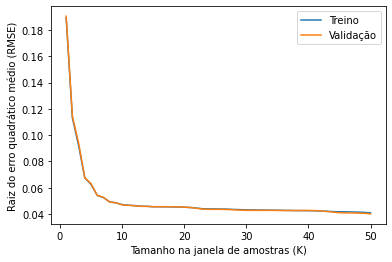

In [9]:
import matplotlib.pyplot as plt

plt.plot(range(1,51), train_mse_list)
plt.plot(range(1,51), validation_mse_list)
plt.legend(["Treino", "Validação"])
plt.xlabel("Tamanho na janela de amostras (K)")
plt.ylabel("Raiz do erro quadrático médio (RMSE)")
plt.show()

# Melhor valor de K - 50

In [10]:
min_rmse = min(validation_mse_list)
min_rmse_index = validation_mse_list.index(min_rmse) + 1
print(f"Menor valor de validação: {min_rmse}, K = {min_rmse_index}")

Menor valor de validação: 0.0400962093508727, K = 50


# 1.2 - Previsão a partir do dataset de teste

In [11]:
x_train, y_train = train_loader.get_data(50, 7)
x_validation, y_validation = validation_loader.get_data(50, 7)
x_test, y_test = test_loader.get_data(50, 7)
x_train_full, y_train_full = full_train_loader.get_data(50,7 )

reg_k50 = LinearRegression().fit(x_train_full, y_train_full)


RMSE: 0.04112359634250055


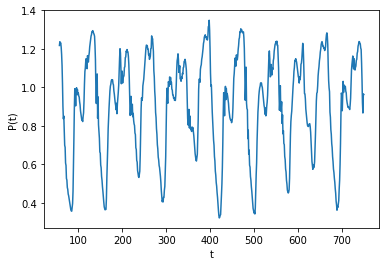

In [12]:
prediction_test = reg_k50.predict(x_test) 
eixo_x = np.array(range(len(x_test))) + 50 + 7


test_rmse = np.sqrt(mean_squared_error(y_test, prediction_test))
print(f"RMSE: {test_rmse}")

plt.plot(eixo_x, prediction_test)
plt.xlabel("t")
plt.ylabel("P(t)")
plt.show()

# Exercício 2

## Testando a geração de atributos

In [13]:
V=5
x_train, y_train = train_loader.get_data(10, 7)
random_attributes = np.random.rand(V, 11) * 0.1
argument = random_attributes.dot(np.asmatrix(x_train[0]).T)
xlinha = np.tanh(argument)
xlinha, argument



(matrix([[0.11200289],
         [0.17808459],
         [0.11084989],
         [0.18424727],
         [0.17271551]]),
 matrix([[0.1124748 ],
         [0.18000385],
         [0.1113073 ],
         [0.18637568],
         [0.17446432]]))

In [14]:
def attribute_transform(samples, V, K):
    transformed_samples = []
    for sample in samples:
        random_attributes = np.random.rand(V, K + 1) * 0.1
        wk_xn = random_attributes.dot(np.asmatrix(sample).T)
        transformed_samples.append(wk_xn)
    transformed_samples = np.array(transformed_samples)
    transformed_samples = np.tanh(transformed_samples)
    transformed_samples = transformed_samples.reshape(transformed_samples.shape[0], -1)
    return transformed_samples

x_train_transf = attribute_transform(x_train, 10, 10)
x_train_transf.shape

(3484, 10)

In [15]:
def normalize_samples(samples):
    min_val = np.amin(samples)
    max_val = np.amax(samples)
    normalized_samples = (samples - min_val)/(max_val - min_val)
    return normalized_samples
x_norm = normalize_samples(x_train_transf)
np.amin(x_norm), np.amax(x_norm)

(0.0, 1.0)

In [16]:
L = 7
K = 10
train_mse_list_transf = []
validation_mse_list_transf = []
for V in range(1,101):
    x_train, y_train = train_loader.get_data(K, L)
    x_validation, y_validation = validation_loader.get_data(K, L)
    x_train = attribute_transform(x_train, V, K)
    x_validation = attribute_transform(x_validation, V, K)
    #x_train = normalize_samples(x_train)
    #x_validation = normalize_samples(x_validation)
    reg = LinearRegression().fit(x_train, y_train)
    train_prediction = reg.predict(x_train)
    validation_prediction = reg.predict(x_validation)
    validation_mse = np.sqrt(mean_squared_error(y_validation, validation_prediction))
    train_mse = np.sqrt(mean_squared_error(y_train, train_prediction))
    train_mse_list_transf.append(train_mse)
    validation_mse_list_transf.append(validation_mse)


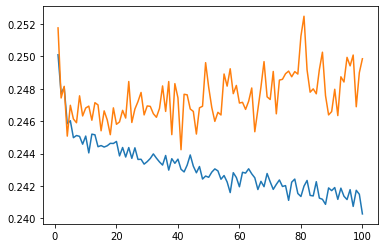

In [17]:
plt.plot(range(1,101), train_mse_list_transf)
plt.plot(range(1,101), validation_mse_list_transf)
plt.show()

In [18]:
alpha_list = [10, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
ridge_regression = Ridge(alpha=10000000, fit_intercept=False)
ridge_regression.fit(x_train, y_train)
validation_prediction = ridge_regression.predict(x_validation)
validation_mse = np.sqrt(mean_squared_error(y_validation, validation_prediction))
validation_mse

0.9426505112502185

In [30]:
from cmath import inf


L = 7
K = 10

alpha_list = [10000, 1000, 100, 10, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 0]
best_alpha = [0] * 100
best_train_mse_list = [inf] * 100
best_validation_mse_list =[inf] * 100
for V in range(1,101):

    x_train, y_train = train_loader.get_data(K, L)
    x_validation, y_validation = validation_loader.get_data(K, L)
    x_train = attribute_transform(x_train, V, K)
    x_validation = attribute_transform(x_validation, V, K)
    for alpha in alpha_list:
        ridge_reg = Ridge(alpha)
        ridge_reg.fit(x_train, y_train)
        train_prediction = ridge_reg.predict(x_train)
        validation_prediction = ridge_reg.predict(x_validation)
        validation_mse = np.sqrt(mean_squared_error(y_validation, validation_prediction))
        train_mse = np.sqrt(mean_squared_error(y_train, train_prediction))
        if validation_mse < best_validation_mse_list[V - 1]:
            best_validation_mse_list[V - 1] = validation_mse
            best_train_mse_list[V-1] = train_mse
            best_alpha[V-1] = alpha



In [35]:
max(best_alpha)

1000

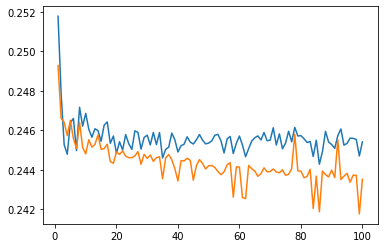

In [31]:
plt.plot(range(1,101), best_validation_mse_list)
plt.plot(range(1,101), best_train_mse_list)
plt.show()

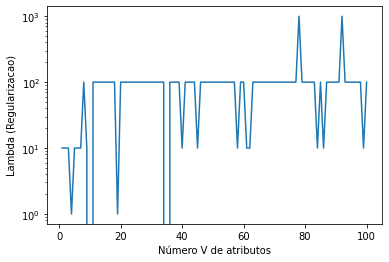

In [40]:
plt.plot(range(1,101), best_alpha)
plt.yscale("log")
plt.xlabel("Número V de atributos")
plt.ylabel("Lambda (Regularizacao)")
plt.show()

In [43]:
min_rmse = min(best_validation_mse_list)
min_rmse_index = best_validation_mse_list.index(min_rmse) + 1
print(f"Menor valor de validação: {min_rmse}, V = {min_rmse_index}, Lambda = {best_alpha[ min_rmse_index - 1]}")

Menor valor de validação: 0.2442830630156172, V = 86, Lambda = 10


RMSE: 0.24727683526944064


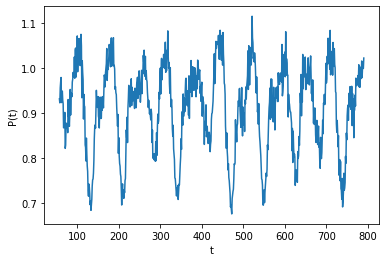

In [50]:
K=10
L=7
V=86
x_train_full, y_train_full = full_train_loader.get_data(K, L)
x_test, y_test = test_loader.get_data(K,L)
x_train_full = attribute_transform(x_train_full, V, K)
x_test = attribute_transform(x_test, V, K)

best_ridge = Ridge(alpha=best_alpha[ min_rmse_index - 1])
best_ridge.fit(x_train_full, y_train_full)

prediction_test = best_ridge.predict(x_test) 
eixo_x = np.array(range(len(x_test))) + 50 + 7


test_rmse = np.sqrt(mean_squared_error(y_test, prediction_test))
print(f"RMSE: {test_rmse}")

plt.plot(eixo_x, prediction_test)
plt.xlabel("t")
plt.ylabel("P(t)")
plt.show()